# Evaluation

This notebook can be used to reproduce most plots and figures from the paper. For 2D level sets, see `levelset_figures.ipynb`.

In [14]:
%load_ext autoreload
%autoreload 2

import sys
import os
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

import numpy as np
np.set_printoptions(linewidth=1000)
np.set_printoptions(threshold=5000)

from tqdm.notebook import tqdm
import os
from functools import partial
from pathlib import Path
import pandas as pd
from datetime import datetime
from PIL import Image
pd.set_option('display.max_rows', 500)

from matplotlib import pyplot as plt
mpl_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
%matplotlib widget

import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

import jax
jax.config.update("jax_enable_x64", False)
import jax.numpy as jnp
import jax.random as jrnd
import orbax

import trimesh
from notebook_utils import *

import diffcd
import evaluation

from fit_implicit import load_config

import matplotlib

def load_checkpoint(experiment_dir: Path, step: int = None):
    checkpoint_manager = orbax.checkpoint.CheckpointManager(
        directory=experiment_dir / 'checkpoints',
        checkpointers=orbax.checkpoint.PyTreeCheckpointer(),
    )
    checkpoint = checkpoint_manager.restore(
        checkpoint_manager.latest_step() if step is None else step,
    )
    return checkpoint

def load_model(output_dir, checkpoint_index, final=False, with_mesh=True, normalize_mesh=False):
    if final:
        mesh_path = output_dir / f'mesh_final_{checkpoint_index}.ply'
    else:
        mesh_path = output_dir / f'meshes/mesh_{checkpoint_index}.ply'
    mesh = trimesh.load(mesh_path) if with_mesh else None
    checkpoint = load_checkpoint(output_dir, checkpoint_index)
    if normalize_mesh:
        # scale mesh to network coordinate system
        mesh.vertices = (mesh.vertices - checkpoint['center_point']) / checkpoint['scale_factor']

    config = load_config(output_dir)
    model = config.model
    params = checkpoint['model']['params']
    return model, params, config, mesh

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# set this to the directory where outputs from fit_implicit.py are stored
base_dir = Path('/home/linus/workspace/outputs/diffcd')

## Shape info

requires blender kernel

In [2]:
import bpy
import blender_plots as bplt
from blender_plots import blender_utils as bu
import math
from notebook_utils_blender import *
import mathutils

mesh_color = np.array([0.4, 0.4, 0.4, 1])
rots = {
    'anchor': [0, 0, -np.pi / 4],
    'dc': [np.pi / 2, 0, 0],
    'gargoyle': [-np.pi / 2, 0, 0],
    'lord_quas': [np.pi / 2, 0, 0],
    'daratech': [np.pi / 2, 0, 0],
}
famous_shapes = [
    "3DBenchy",
    "Armadillo",
    "Cup34",
    "Liberty",
    "LibertyBase",
    "Utah_teapot_(solid)",
    "angel",
    "bunny",
    "column",
    "dragon",
    "eg07_dragon_original",
    "flower",
    "galera",
    "hand",
    "happy",
    "horse",
    "netsuke",
    "serapis",
    "tortuga",
    "xyzrgb_statuette",
    "yoda",
    "xyzrgb_dragon_clean",
]
shape_rots = {
    "3DBenchy": [1.973491, 0.565872, 0.397071],
    "Armadillo": [1.279329, -0.523505, -1.873030],
    "Cup34": [1.549294, -0.002934, -8.273785],
    "Liberty": [1.549294, -0.002934, -8.273785],
    "LibertyBase": [1.570796, -0.000000, -1.570796],
    "Utah_teapot_(solid)": [0.208537, 1.226459, -4.230667],
    "angel": [1.697227, -2.569600, 1.993524],
    "bunny": [1.570796, 2.560063, 1.436140],
    "column": [1.570796, -0.000000, -0.856408],
    "dragon": [3.614511, 1.313700, -2.598450],
    "eg07_dragon_original": [-0.039995, 2.332894, -1.740092],
    "flower": [1.570796, -0.000000, -1.570796],
    "galera": [1.586949, 3.807761, -2.121951],
    "hand": [-1.222986, 0.369399, -1.209566],
    "happy": [1.374851, -1.043912, -1.312685],
    "horse": [0.800892, -0.648794, -4.601765],
    "netsuke": [2.704684, -2.292917, -3.792721],
    "serapis": [2.679568, 3.240767, -1.841576],
    "tortuga": [1.994344, -0.779336, -1.327590],
    "xyzrgb_statuette": [1.884367, 2.601276, -0.911202],
    "yoda": [1.290503, -8.341380, -1.758422],
    "xyzrgb_dragon_clean": [-6.417248, 0.761268, -1.406844],
}
shape_scales = {
    "3DBenchy": 1.62193,
    "Armadillo": 1.406,
    "Cup34": 1.35815,
    "Liberty": 1.76884,
    "LibertyBase": 1.,
    "Utah_teapot_(solid)": 1.69715,
    "angel": 1.57988,
    "bunny": 1.33726,
    "column": 1.60766,
    "dragon": 1.504,
    "eg07_dragon_original": 1.40351,
    "flower": 1.51258,
    "galera": 1.44836,
    "hand": 1.5374,
    "happy": 1.49781,
    "horse": 1.45101,
    "netsuke": 1.35697,
    "serapis": 1.35714,
    "tortuga": 1.78173,
    "xyzrgb_statuette": 1.470132,
    "yoda": 1.79178,
    "xyzrgb_dragon_clean": 1.64108,
}
shape_offsets = {
    "3DBenchy": [0.079599, 0.000000, 0.208712],
    "Armadillo": [0.016001, 0.000000, 0.065363],
    "Cup34": [0, 0, 0],
    "Liberty": [0.000000, 0.000000, 0.245872],
    "LibertyBase": [0, 0, 0],
    "Utah_teapot_(solid)": [0.116799, 0.000000, 0.114277],
    "angel": [0.000000, 0.000000, 0.125678],
    "bunny": [0.061397, 0.000000, 0.154598],
    "column": [0, 0, 0],
    "dragon": [0.109435, -0.109496, 0.171271],
    "eg07_dragon_original": [-0.012576, 0.000000, -0.019602],
    "flower": [0, 0, 0],
    "galera": [0.000000, 0.000000, 0.101243],
    "hand": [0.000000, 0.000000, 0.032701],
    "happy": [0.000000, 0.000000, 0.078420],
    "horse": [0.000000, 0.000000, 0.062099],
    "netsuke": [0.000000, 0.000000, 0.040873],
    "serapis": [0.000000, 0.000000, 0.109389],
    "tortuga": [-0.094460, 0.000000, 0.046627],
    "xyzrgb_statuette": [-0.043312, 0.000000, 0.078419],
    "yoda": [0.144047, 0.000000, 0.068654],
    "xyzrgb_dragon_clean": [0.091593, 0.000000, 0.178902],
}

shape_R = {shape_name: euler_to_R(rot) for shape_name, rot in shape_rots.items()}


abc_shapes = [
    '00010218_4769314c71814669ba5d3512_trimesh_013',
    '00010429_fc56088abf10474bba06f659_trimesh_004',
    '00011000_8a21002f126e4425a811e70a_trimesh_004',
    '00011171_db6e2de6f4ae4ec493ebe2aa_trimesh_047',
    '00011563_26a622427a024bf3af381ee6_trimesh_014',
    '00011602_c087f04c99464bf7ab2380c4_trimesh_000',
    '00011696_1ca1ad2a09504ff1bf83cf74_trimesh_029',
    '00011827_73c6505f827541168d5410e4_trimesh_096',
    '00012076_bd0ba1071db44a4cb05e612c_trimesh_011',
    '00012275_eb932687cefd46ec9539dff8_trimesh_012',
    '00012324_4abcf5e80b7e46eeae89a8d1_trimesh_011',
    '00012451_f54bcfcb352445bf90726b58_trimesh_001',
    '00012754_b17656deace54b61b3130c7e_trimesh_019',
    '00012756_b17656deace54b61b3130c7e_trimesh_021',
    '00012809_c478c020bc394c7a9ee59016_trimesh_000',
    '00012830_9302b464ff7a454a9404b130_trimesh_001',
    '00013052_9084b77631834dd584b2ac93_trimesh_033',
    '00013453_056d6da46d5d4183875e63e0_trimesh_000',
    '00013698_4e525fcfdb0b458fbe78eff7_trimesh_007',
    '00013858_5f60dba564944f9fbb15dc2c_trimesh_001',
    '00014101_7b2cf2f0fd464e80a5062901_trimesh_000',
    '00014155_a04f003ab9b74295bbed8248_trimesh_000',
    '00014221_57e4213b31844b5b95cc62cd_trimesh_000',
    '00014228_fb174aafb16d47abab609285_trimesh_002',
    '00014393_4898b9df95db421ca3eeae4d_trimesh_022',
    '00014405_4898b9df95db421ca3eeae4d_trimesh_034',
    '00014452_55263057b8f440a0bb50b260_trimesh_017',
    '00014489_f4297f01e3434034b7051ebb_trimesh_004',
    '00014859_1d8dd0a5ddec465fad59927b_trimesh_009',
    '00014952_e862f9e2bc81472a91a31206_trimesh_001',
    '00015156_57353d3381fb481182d9bdc6_trimesh_010',
    '00015159_57353d3381fb481182d9bdc6_trimesh_013',
]

thing_shapes = [
    '103354',
    '120477',
    '199664',
    '236159',
    '252119',
    '274379',
    '313444',
    '316358',
    '331105',
    '353684',
    '353686',
    '354371',
    '398259',
    '42468',
    '44234',
    '46459',
    '46460',
    '46461',
    '46462',
    '46463',
    '47984',
    '527631',
    '53159',
    '53920',
    '54725',
    '58982',
    '59941',
    '64194',
    '64444',
    '64764',
    '68380',
    '68381',
    '70558',
    '70559',
    '72870',
    '72879',
    '72881',
    '72896',
    '72947',
    '72948',
    '72960',
    '73075',
    '73101',
    '73133',
    '73998',
    '75147',
    '75275',
    '75496',
    '75650',
    '75651',
    '75652',
    '75653',
    '75654',
    '75655',
    '75656',
    '75657',
    '75658',
    '75659',
    '75660',
    '75661',
    '75662',
    '75663',
    '75665',
    '75667',
    '75810',
    '76277',
    '76391',
    '76947',
    '76948',
    '77245',
    '77319',
    '77513',
    '78671',
    '79241',
    '80650',
    '81368',
    '81369',
    '81528',
    '81762',
    '82536',
    '83022',
    '83229',
    '84986',
    '85540',
    '85546',
    '85699',
    '86848',
    '88053',
    '90889',
    '91347',
    '92763',
    '92880',
    '93101',
    '93497',
    '93989',
    '95187',
    '95444',
    '96483',
    '96637',
    '98480',
]

# default camera pose for rendering
camera_location = [-0.991957, -2.175998, 0.181080]
camera_rotation = [1.523696, 0.000002, -0.431984]

## Single-shape visualizaton

visualize the shape obtained from `fit_implicit.py` along with the input point cloud

In [7]:
results_dir = base_dir / 'run-famous_noisefree-diffcd-implicit-256-l2-lr0.001-2024-02-12_12:23:27/bunny/'
shape_path = results_dir / 'mesh_final_40000.ply'

rotation = shape_rots['bunny']
offset = shape_offsets['bunny']

setup_scene(
	clear=True,
	camera_location=camera_location,
	camera_rotation=camera_rotation,
	resolution=(512, 512)
)

# plot extracted mesh
plot_mesh(
	shape_path,
	name=f'shape',
	color=mesh_color,
	rotation=rotation,
	offset=offset,
)

# plot point cloud
checkpoint = load_checkpoint(results_dir, 0)
train_points = np.load(results_dir / 'train_points.npy')
train_points = train_points * checkpoint['scale_factor'] + checkpoint['center_point']
scatter = bplt.Scatter(
    train_points,
    marker_type='ico_spheres',
	radius=0.007,
	subdivisions=1,
	color=hex_to_rgb(0x71863),
	name=f"train_points",
)
scatter.base_object.rotation_euler = rotation
scatter.base_object.location = offset

render_image('render.png', resolution=(512, 512), samples=200)

2024-07-26 16:01:09.596566: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Saved: 'render.png'
Time: 00:04.47 (Saving: 00:00.09)



## Tables

### Load experiments results

Uncomment lines corresponding to the methods to evalute. Each `experiment` shoud be a tuple of `(name, experiment_dir)` where `experiment_dir` contains the subfolder for each shape

Experiment names starting with "o" (for "original") are using the base learning rate and eikonal weight as described in the appendix.

In [8]:
from fit_implicit import TrainingConfig, CustomCheckpointManagerOptions

results_famous = []

### Famous
shapes = famous_shapes
experiments = [
    ### Noisefree
    ('Neural-Pull', 'run-famous_noisefree-neural-pull-2024-02-08_21:10:19'),
    ('IGR', 'run-famous_noisefree-igr-l2-2024-02-10_15:41:30'),
    ('SIREN $(\\mu\\equal 0.033)$', 'run-famous_noisefree-igr-surfacearea-a100-mixUniform-l2-ew0.1-aw0.033-lr0.001-2024-02-22_18:23:01'),
    ('SIREN $(\\mu\\equal 0.33)$', 'run-famous_noisefree-igr-surfacearea-a100-mixUniform-l2-ew0.1-aw0.33-lr0.001-2024-02-22_23:45:54'),
    ('DiffCD (ours)', 'run-famous_noisefree-diffcd-implicit-256-l2-lr0.001-2024-02-12_12:23:27'),


    ### Original ("o" means without eikonal weight adjustment)
    # ('Neural-Pull', 'run-famous_original-neural-pull-2024-02-08_21:10:32'),
    # ('oIGR', 'run-famous_original-igr-l2-lr0.001-2024-02-12_16:22:31'),
    # ## ('IGR', 'run-famous_original-igr-l2-ew0.5-aw0.0-lr0.001-2024-03-05_22:40:27'), # several folders went missing(?)
    # ('IGR', 'run-famous_original-igr-l2-ew0.5-aw0.0-lr0.001-2024-03-12_13:55:49'),
    # ('oSIREN $(\\mu\\equal 0.033)$', 'run-famous_original-igr-surfacearea-a100-mixUniform-l2-ew0.1-aw0.033-lr0.001-2024-02-29_15:01:34'),
    # ('oSIREN $(\\mu\\equal 0.33)$', 'run-famous_original-igr-surfacearea-a100-mixUniform-l2-ew0.1-aw0.33-lr0.001-2024-02-29_17:19:49'),
    # ('SIREN $(\\mu\\equal 0.033)$', 'run-famous_original-igr-surfacearea-a100-mixUniform-l2-ew0.5-aw0.033-lr0.001-2024-02-29_15:02:57'),
    # ('SIREN $(\\mu\\equal 0.33)$', 'run-famous_original-igr-surfacearea-a100-mixUniform-l2-ew0.5-aw0.33-lr0.001-2024-03-01_01:36:32'),
    # ('oDiffCD (ours)', 'run-famous_original-diffcd-implicit-256-l2-lr0.001-2024-02-12_16:22:18'),
    # ('DiffCD (ours)', 'run-famous_original-diffcd-implicit-256-l2-ew0.5-lr0.001-2024-02-17_19:07:13'),

    ### Max noise
    # ('oNeural-Pull', 'run-famous_extra_noisy-neural-pull-2024-02-08_21:12:35'),
    # ('Neural-Pull', 'run-famous_extra_noisy-neural-pull-l2-ew0.0-aw0.0-lr5e-05-2024-02-20_13:31:42'),
    # ('oIGR', 'run-famous_extra_noisy-igr-l2-lr0.001-2024-02-10_19:26:25'),
    # ('IGR', 'run-famous_extra_noisy-igr-l2-ew1-aw0.0-lr5e-05-2024-02-20_13:16:19'),
    # ('oSIREN $(\\mu\\equal 0.033)$', 'run-famous_extra_noisy-igr-surfacearea-a100-mixUniform-l2-ew0.1-aw0.033-lr0.001-2024-03-01_01:46:43'),
    # ('oSIREN $(\\mu\\equal 0.33)$', 'run-famous_extra_noisy-igr-surfacearea-a100-mixUniform-l2-ew0.1-aw0.33-lr0.001-2024-03-12_14:06:31'),
    # ('SIREN $(\\mu\\equal 0.033)$', 'run-famous_extra_noisy-igr-surfacearea-a100-mixUniform-l2-ew1-aw0.033-lr5e-05-2024-03-01_01:50:11'),
    # ('SIREN $(\\mu\\equal 0.33)$', 'run-famous_extra_noisy-igr-surfacearea-a100-mixUniform-l2-ew1-aw0.33-lr5e-05-2024-03-01_12:52:12'),
    # ('oDiffCD (ours)', 'run-famous_extra_noisy-diffcd-implicit-256-l2-lr0.001-2024-02-12_22:51:48'),
    # ('DiffCD (ours)', 'run-famous_extra_noisy-diffcd-implicit-256-l2-ew1.0-lr5e-05-2024-02-15_00:24:21'),
]

### Thingi10k noise free
# base_dir = Path('/mnt/dcp_outputs/thingi10k')
# shapes = thing_shapes
# experiments = [
#     # ('Neural-Pull', 'run-thingi10k_scans_noisefree-neural-pull-l2-ew0.0-aw0.0-lr0.001-2024-03-04_19:23:39'),
#     ('IGR', 'run-thingi10k_scans_noisefree-igr-l2-ew0.1-aw0.0-lr0.001-2024-03-04_16:54:18'),
#     # ('SIREN $(\\mu\\equal 0.033)$', 'run-thingi10k_scans_noisefree-igr-surfacearea-a100-mixUniform-l2-ew0.1-aw0.033-lr0.001-2024-03-04_01:22:27'),
#     # ('SIREN $(\\mu\\equal 0.33)$', 'run-thingi10k_scans_noisefree-igr-surfacearea-a100-mixUniform-l2-ew0.1-aw0.33-lr0.001-2024-03-05_00:40:35'),
#     # ('DiffCD (ours)', 'run-thingi10k_scans_noisefree-diffcd-implicit-256-l2-ew0.1-aw0.0-lr0.001-2024-03-04_01:18:59'),
# ]

for experiment_label, experiment_name in tqdm(experiments):
    experiment_dir = base_dir / experiment_name

    for i, shape_name in enumerate(tqdm(shapes, leave=False)):
        metrics_path = experiment_dir / shape_name / 'eval_metrics_final_40000.csv'
        if os.path.exists(metrics_path):
            config = load_config(experiment_dir / shape_name)
            results_famous.append(pd.read_csv(metrics_path).assign(
                shape_name=shape_name,
                experiment_name=experiment_name,
                experiment_label=experiment_label,
                dataset=config.dataset.path.parts[-3],
                eikonal_weight=config.method.eikonal_weight,
                learning_rate=config.learning_rate,
                method=config.method,
                distance_metric=config.method.distance_metric,
            ))
        else:
            print('missing', metrics_path)
            raise ValueError(f'missing {metrics_path}')
results_famous = pd.concat(results_famous)
print(results_famous.groupby('experiment_label').size())
print(results_famous.groupby('experiment_label').eikonal_weight.unique())
print(results_famous.groupby('experiment_label').learning_rate.unique())
print(results_famous.groupby('experiment_label').distance_metric.unique())
print(results_famous.dataset.unique())

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

experiment_label
DiffCD (ours)                22
IGR                          22
Neural-Pull                  22
SIREN $(\mu\equal 0.033)$    22
SIREN $(\mu\equal 0.33)$     22
dtype: int64
experiment_label
DiffCD (ours)                [0.1]
IGR                          [0.1]
Neural-Pull                  [0.0]
SIREN $(\mu\equal 0.033)$    [0.1]
SIREN $(\mu\equal 0.33)$     [0.1]
Name: eikonal_weight, dtype: object
experiment_label
DiffCD (ours)                [0.001]
IGR                          [0.001]
Neural-Pull                  [0.001]
SIREN $(\mu\equal 0.033)$    [0.001]
SIREN $(\mu\equal 0.33)$     [0.001]
Name: learning_rate, dtype: object
experiment_label
DiffCD (ours)                [l2]
IGR                          [l2]
Neural-Pull                  [l2]
SIREN $(\mu\equal 0.033)$    [l2]
SIREN $(\mu\equal 0.33)$     [l2]
Name: distance_metric, dtype: object
['famous_noisefree']


### Print table

For copying into latex

In [9]:
experiment_labels = [
    # 'oNeural-Pull',
    # 'oIGR',
    # 'oSIREN $(\\mu\\equal 0.033)$',
    # 'oSIREN $(\\mu\\equal 0.33)$',
    # 'oDiffCD (ours)',
    'Neural-Pull',
    'IGR',
    'SIREN $(\\mu\\equal 0.033)$',
    'SIREN $(\\mu\\equal 0.33)$',
    'DiffCD (ours)',
]
datasets = [
    'famous_noisefree',
    # 'famous_original',
    # 'famous_extra_noisy',
    # 'thingi10k_scans_noisefree'
]
for experiment_label in experiment_labels:
    print(experiment_label)
    for dataset in datasets:
        sub_table = get_df(
            results_famous,
            experiment_label=experiment_label,
            dataset=dataset,
        )
        assert len(sub_table) in [len(shapes), len(shapes) - 1]
        for metric, metric_scale, n_decimals in [
                ('chamfer_distance', 100, 3),
                ('chamfer_square_distance', 100**2, 3),
                ('chamfer_normal_angle', 1, 1),
            ]:
            metric_value = sub_table[metric].mean() * metric_scale
            is_best_method = get_df(results_famous[results_famous.experiment_label.apply(lambda l: l in experiment_labels)], dataset=dataset).groupby(['experiment_label'])[metric].mean().idxmin() == experiment_label
            if is_best_method:
                print('& ' + '\\textbf{' + f'{metric_value:.{n_decimals}f}' + '} ', end='')
            else:
                print(f'& {metric_value:.{n_decimals}f} ', end='')
        print()
    print('\\\\\n')

Neural-Pull
& 0.641 & 1.851 & 21.1 
\\

IGR
& 0.772 & 3.092 & 23.0 
\\

SIREN $(\mu\equal 0.033)$
& 0.602 & 1.151 & 22.1 
\\

SIREN $(\mu\equal 0.33)$
& 0.605 & 1.525 & 19.2 
\\

DiffCD (ours)
& \textbf{0.518} & \textbf{0.542} & \textbf{17.5} 
\\



## Shape grid

If `render` is set to True the shapes are rendered individually and a .png grid is saved, otherise the meshes are arranged into a grid in blender and no .png is saved

### Optimization-based methods

Visualize the multiple outputs of `fit_implicit.py`

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Saved: 'images/results-grid-run-famous_noisefree-diffcd-implicit-256-l2-lr0.001-2024-02-12_12:23:27/2024-07-26_16:03:52/3DBenchy.png'
Time: 00:04.71 (Saving: 00:00.08)

Saved: 'images/results-grid-run-famous_noisefree-diffcd-implicit-256-l2-lr0.001-2024-02-12_12:23:27/2024-07-26_16:03:52/Armadillo.png'
Time: 00:02.98 (Saving: 00:00.02)

Saved: 'images/results-grid-run-famous_noisefree-diffcd-implicit-256-l2-lr0.001-2024-02-12_12:23:27/2024-07-26_16:03:52/Cup34.png'
Time: 00:06.49 (Saving: 00:00.02)

Saved: 'images/results-grid-run-famous_noisefree-diffcd-implicit-256-l2-lr0.001-2024-02-12_12:23:27/2024-07-26_16:03:52/Liberty.png'
Time: 00:02.24 (Saving: 00:00.02)

Saved: 'images/results-grid-run-famous_noisefree-diffcd-implicit-256-l2-lr0.001-2024-02-12_12:23:27/2024-07-26_16:03:52/LibertyBase.png'
Time: 00:03.31 (Saving: 00:00.02)

Saved: 'images/results-grid-run-famous_noisefree-diffcd-implicit-256-l2-lr0.001-2024-02-12_12:23:27/2024-07-26_16:03:52/Utah_teapot_(solid).png'
Time: 00:0

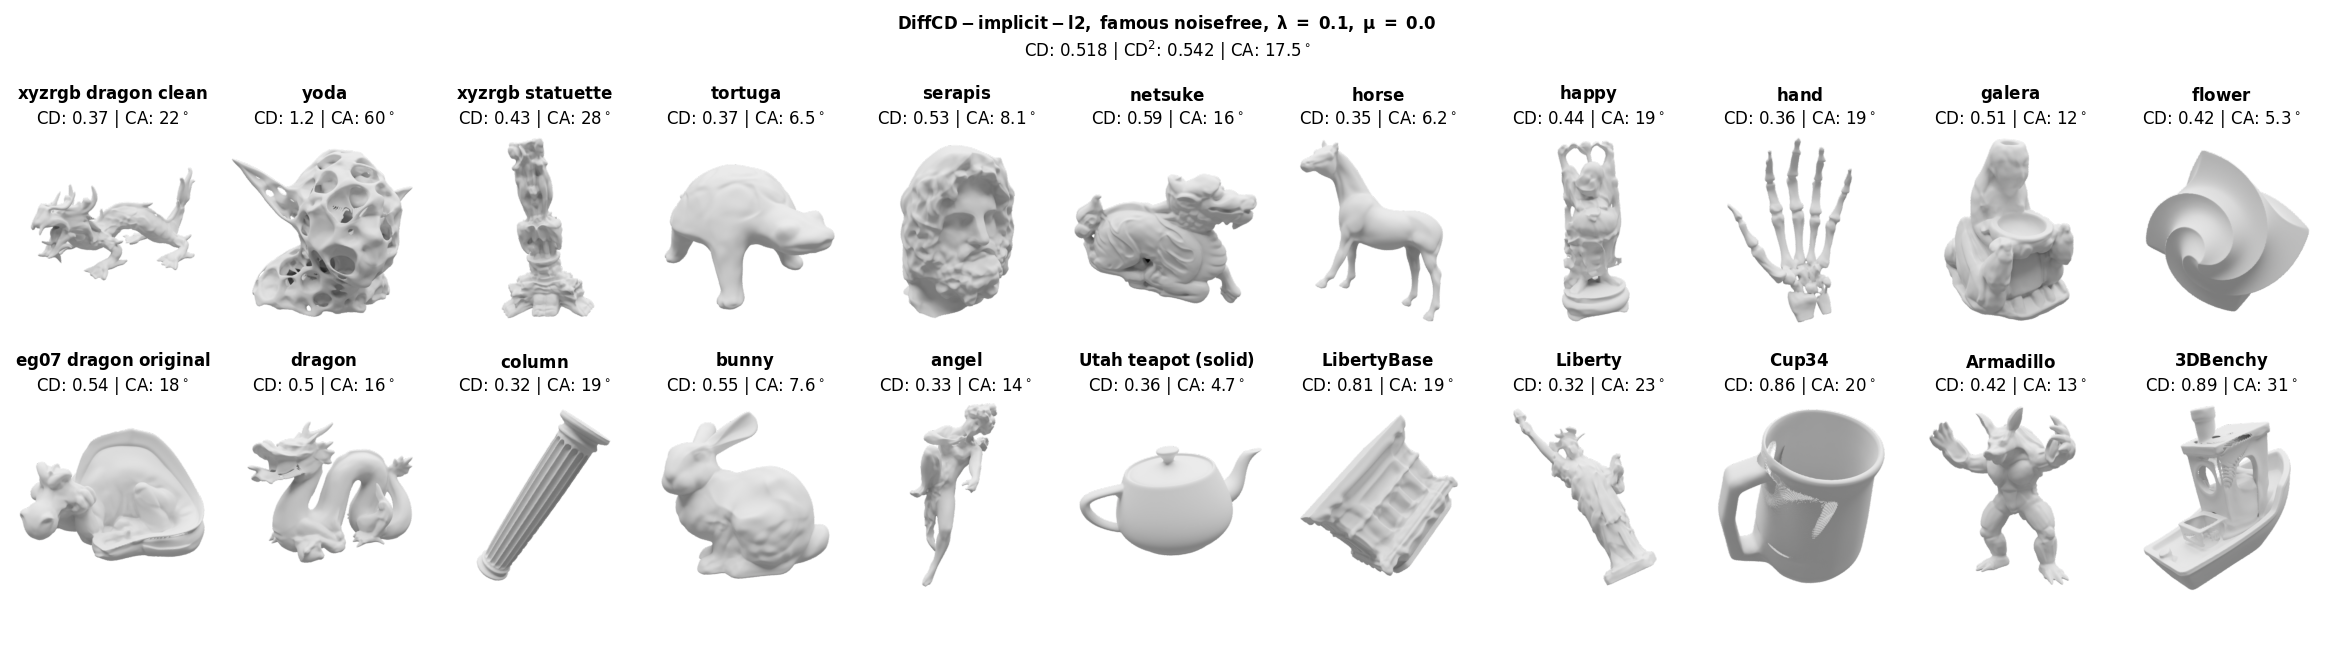

In [6]:
from fit_implicit import TrainingConfig, CustomCheckpointManagerOptions

shapes = famous_shapes
# shapes = thing_shapes

# Path to directory where rendered images will be stored
images_base_dir = Path('images')

render = True
method_names = {
    'NeuralPull': 'Neural Pull',
    'IGR': 'IGR',
    'DiffCD': 'DiffCD',
}

for experiment_name in [
        'run-famous_noisefree-diffcd-implicit-256-l2-lr0.001-2024-02-12_12:23:27',
    ]:
    experiment_dir = base_dir / experiment_name

    # load metrics
    results_famous = []
    for i, shape_name in enumerate(tqdm(shapes)):
        metrics_path = experiment_dir / shape_name / 'eval_metrics_final_40000.csv'
        if os.path.exists(metrics_path):
            config = load_config(experiment_dir / shape_name)
            results_famous.append(pd.read_csv(metrics_path).assign(
                shape_name=shape_name,
                dataset=config.dataset.path.parts[-3],
                eikonal_weight=config.method.eikonal_weight,
                surface_area_weight=getattr(config.method, 'surface_area_weight', 0),
                method=method_names[config.method.__class__.__name__] + ('-implicit' if getattr(config.method, 'p2s_loss', None) == 'implicit' else '') + f'-{config.method.distance_metric}',
            ))
        else:
            print('missing', metrics_path)
    results_famous = pd.concat(results_famous).reset_index()

    if render:
        side = 512
        timestamp_str = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
        images_dir = images_base_dir / f'results-grid-{experiment_name}/{timestamp_str}'
        images_dir.mkdir(parents=True, exist_ok=False)
        images = []

    for i, shape_name in enumerate(tqdm(shapes)):
        if render:
            setup_scene(clear=True, camera_location=camera_location, camera_rotation=camera_rotation)
        mesh_path = experiment_dir / shape_name / 'mesh_final_40000.ply'
        offset = np.zeros(3) if render else np.array([i, 0, 0])

        if os.path.exists(mesh_path):
            mesh_object, scatter = plot_mesh(
                mesh_path, name=f'{shape_name}', color=mesh_color,
                offset=offset + np.array(shape_offsets[shape_name]), rotation=shape_rots[shape_name], scale=shape_scales[shape_name]
            )
        else:
            print('missing', mesh_path)

        if render:
            output_path = images_dir / f"{shape_name}.png"
            render_image(str(output_path), resolution=(side, side), samples=200)
            images.append(np.array(Image.open(output_path)))

    if render:
        img_grid = np.concatenate([
            np.concatenate(images[len(shapes) // 2:][::-1], axis=-2),
            np.concatenate(images[:len(shapes) // 2][::-1], axis=-2),
        ], axis=0)
        Image.fromarray(img_grid).save(images_dir / 'grid.png')

        fig, axes = plt.subplots(2, len(shapes) // 2, figsize=(23.34,  6.59))
        for i, image in enumerate(images):
            shape_name = shapes[i]
            ax = axes.ravel()[::-1][i]
            ax.imshow(image)

            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.tick_params(left=False, bottom=False)
            ax.set_xticks([])
            ax.set_yticks([])

            row = get_df(results_famous, shape_name=shape_name)
            if len(row) == 1:
                row = row.iloc[0]
                metrics_str = f"""\nCD: {row.chamfer_distance*100:.2g} | CA: {row.chamfer_normal_angle:.2g}""" + r"$^\circ$"
            else:
                metrics_str = "\n"
            ax.set_title(bold(shape_name) + metrics_str)
        method, dataset, ew, aw = get_unique(results_famous, 'method'), get_unique(results_famous, 'dataset'), get_unique(results_famous, 'eikonal_weight'), get_unique(results_famous, 'surface_area_weight')
        fig.suptitle(bold(method + ", " + dataset + f', \\lambda = {ew}, \\mu = {aw}') + f"""\nCD: {results_famous.chamfer_distance.mean()*100:.3f} | CD{r'$^2$'}: {results_famous.chamfer_square_distance.mean()*100**2:.3f} | CA: {results_famous.chamfer_normal_angle.mean():.1f}"""  + r"$^\circ$")
        fig.tight_layout()

        fig.savefig(images_dir / f'grid_metrics.png', bbox_inches='tight', pad_inches=0.1)

### Learning-based methods

Evaluate and visualize outputs of learning-based methods, as well as the official implementations of Neural-Pull. Modify the paths in the cells below to match where outputs are stored.

In [7]:
baseline = 'POCO'
dataset = 'FamousTestNoiseFree'
# dataset = 'FamousTestOriginal'
# dataset = 'FamousTestExtraNoisy'
# dataset = 'Thingi10kTestNoiseFree'
experiment_names = [f'POCO-{dataset}']

In [16]:
baseline = 'points2surf'
dataset = 'famous_noisefree'
# dataset = 'famous_original'
# dataset = 'famous_extra_noisy'
# dataset = 'thingi10k_scans_noisefree'
experiment_names = [f'points2surf-{dataset}']

In [ ]:
experiment_names = ['Neural Pull (tf)']
baseline = 'Neural Pull (tf)'

In [ ]:
baseline = 'NKSR'
experiment_names = ['nksr']
# dataset = 'famous_noisefree_abc-w-shapenet-normals-scaled'
# dataset = 'famous_original_abc-w-shapenet-normals-scaled'
dataset = 'famous_extra_noisy_abc-w-gt-normals-vs0.08-scaled'

  0%|          | 0/22 [00:00<?, ?it/s]

Saved: '/home/linus/Pictures/closest_point/renders-famous-pytorch/results-grid-POCO-FamousTestNoiseFree/2024-07-26_16:06:31/3DBenchy.png'
Time: 00:05.87 (Saving: 00:00.02)

Saved: '/home/linus/Pictures/closest_point/renders-famous-pytorch/results-grid-POCO-FamousTestNoiseFree/2024-07-26_16:06:31/Armadillo.png'
Time: 00:03.58 (Saving: 00:00.02)

Saved: '/home/linus/Pictures/closest_point/renders-famous-pytorch/results-grid-POCO-FamousTestNoiseFree/2024-07-26_16:06:31/Cup34.png'
Time: 00:07.28 (Saving: 00:00.02)

Saved: '/home/linus/Pictures/closest_point/renders-famous-pytorch/results-grid-POCO-FamousTestNoiseFree/2024-07-26_16:06:31/Liberty.png'
Time: 00:02.45 (Saving: 00:00.02)

Saved: '/home/linus/Pictures/closest_point/renders-famous-pytorch/results-grid-POCO-FamousTestNoiseFree/2024-07-26_16:06:31/LibertyBase.png'
Time: 00:03.79 (Saving: 00:00.02)

Saved: '/home/linus/Pictures/closest_point/renders-famous-pytorch/results-grid-POCO-FamousTestNoiseFree/2024-07-26_16:06:31/Utah_teapot

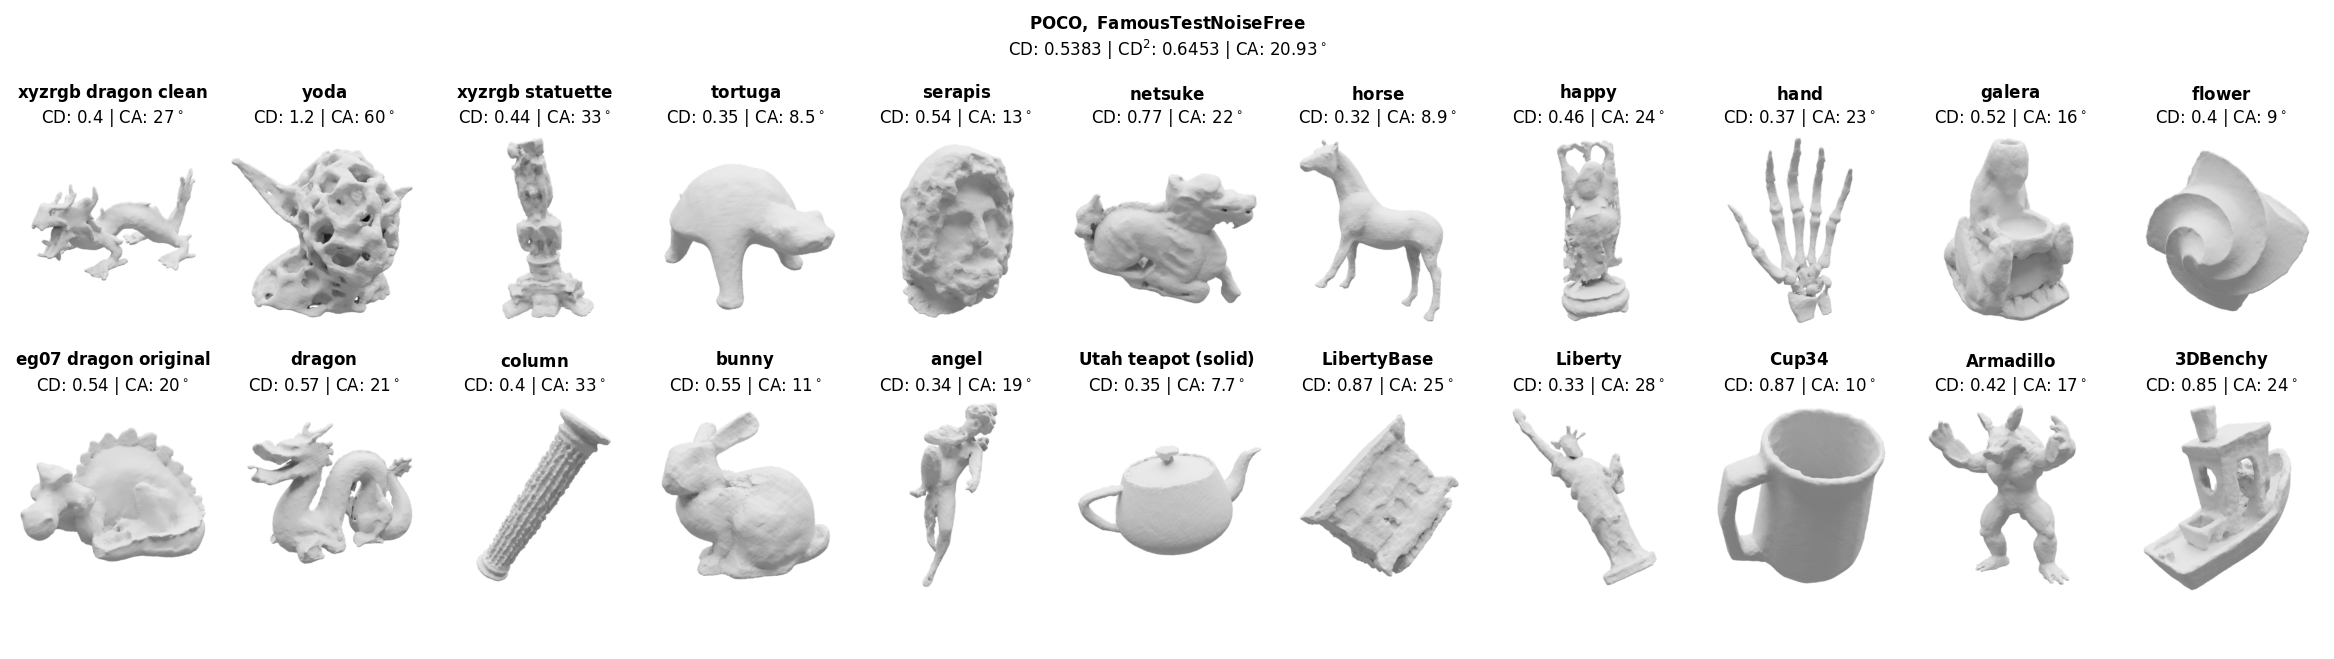

In [8]:
def scale_output(vertices, pointcloud):
    shape_scale = np.max([np.max(pointcloud[:,0])-np.min(pointcloud[:,0]),np.max(pointcloud[:,1])-np.min(pointcloud[:,1]),np.max(pointcloud[:,2])-np.min(pointcloud[:,2])])
    shape_center = [(np.max(pointcloud[:,0])+np.min(pointcloud[:,0]))/2, (np.max(pointcloud[:,1])+np.min(pointcloud[:,1]))/2, (np.max(pointcloud[:,2])+np.min(pointcloud[:,2]))/2]

    return shape_scale * vertices + shape_center


render = True

# shape_names = thing_shapes
# gt_shapes = 'thingi10k_scans_noisefree'
shape_names = famous_shapes
gt_shapes = 'famous_noisefree'

for j, experiment_name in enumerate(experiment_names):
    if baseline == 'points2surf':
        experiment_dir = Path(f'results_512/p2s_vanilla_model_149/{dataset}/rec/mesh')
    elif baseline == 'Neural Pull (pytorch)':
        experiment_dir = Path('/mnt/dcp_outputs/neural-pull-pytorch') / experiment_name
    elif baseline == 'Neural Pull (tf)':
        experiment_dir = Path('/home/linus/workspace/data/neural_pull/famous_noisefree_sur/')
    elif baseline == 'NKSR':
        experiment_dir = Path('/home/linus/workspace/results/nksr') / dataset
    n_samples = 30000
    metrics = []

    if render:
        side = 512
        timestamp_str = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
        images_dir = Path(f'/home/linus/Pictures/closest_point/renders-famous-pytorch/results-grid-{experiment_name}/{timestamp_str}')
        images_dir.mkdir(parents=True, exist_ok=False)
        images = []

    for i, shape_name in enumerate(tqdm(shape_names)):
        gt_mesh = trimesh.load(f'/home/linus/workspace/points2surf/datasets/{gt_shapes}/03_meshes/{shape_name}.ply')

        if baseline == 'points2surf':
            mesh_path = f'/home/linus/workspace/points2surf/results/p2s_vanilla_model_149/{dataset}/rec/mesh/{shape_name}.ply'
        elif baseline == 'POCO':
            mesh_path = f'/home/linus/workspace/POCO/results/ABC_10k_FKAConv_InterpAttentionKHeadsNet_None/gen_{dataset}_test_10000/meshes/04_pts/{shape_name}.ply'
        elif baseline == 'Neural Pull (pytorch)':
            mesh_path = experiment_dir / shape_name / 'outputs/00040000_0.0.ply'
            if not os.path.exists(mesh_path):
                mesh_path = experiment_dir / shape_name / 'outputs/00040000_0.005.ply'
            if not os.path.exists(mesh_path):
                mesh_path = experiment_dir / shape_name / 'outputs/00040000_-0.005.ply'
        elif baseline in ['Neural Pull (tf)', 'NKSR']:
            mesh_path = experiment_dir / f'{shape_name}.ply'
        else:
            raise ValueError(f'{baseline=} not recognized')
        mesh_np = trimesh.load(mesh_path)
        if baseline == 'Neural Pull (pytorch)':
            pointcloud = np.load(f'/home/linus/workspace/data/points2surf/famous_noisefree/04_pts/{shape_name}.xyz.npy')
            mesh_np.vertices = scale_output(mesh_np.vertices, pointcloud) # undo scaling from NeuralPull-Pytorch/models/dataset.py


        if render:
            setup_scene(clear=True, camera_location=[-0.991957, -2.175998, 0.181080], camera_rotation=[1.523696, 0.000002, -0.431984])
        offset = np.zeros(3) if render else np.array([i, 0, 0])
        mesh_object, scatter = plot_mesh(
            mesh_np, name=f'{experiment_name}-{shape_name}', color=mesh_color,
            offset=offset + np.array(shape_offsets[shape_name]), scale=shape_scales[shape_name], rotation=shape_rots[shape_name]
        )

        if render:
            output_path = images_dir / f"{shape_name}.png"
            render_image(str(output_path), resolution=(side, side), samples=200)
            images.append(np.array(Image.open(output_path)))

        chamfer_metrics = evaluation.chamfer.compute_chamfer(mesh_np, gt_mesh, n_samples)
        metrics.append({
            'shape': shape_name,
            **chamfer_metrics,
            'n_samples': n_samples,
        })

    if render:
        metrics = pd.DataFrame(metrics).assign(dataset=f'{dataset}')
        img_grid = np.concatenate([
            np.concatenate(images[len(famous_shapes) // 2:][::-1], axis=-2),
            np.concatenate(images[:len(famous_shapes) // 2][::-1], axis=-2),
        ], axis=0)
        Image.fromarray(img_grid).save(images_dir / 'grid.png')

        fig, axes = plt.subplots(2, len(famous_shapes) // 2, figsize=(23.34,  6.59))
        for i, image in enumerate(images):
            shape_name = famous_shapes[i]
            ax = axes.ravel()[::-1][i]
            ax.imshow(image)

            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.tick_params(left=False, bottom=False)
            ax.set_xticks([])
            ax.set_yticks([])

            row = get_df(metrics, shape=shape_name)
            if len(row) == 1:
                row = row.iloc[0]
                metrics_str = f"""\nCD: {row.chamfer_distance*100:.2g} | CA: {row.chamfer_normal_angle:.2g}""" + r"$^\circ$"
            else:
                metrics_str = "\n"
            ax.set_title(bold(shape_name) + metrics_str)
        fig.suptitle(bold(f"{baseline}, " + row.dataset) + f"""\nCD: {metrics.chamfer_distance.mean()*100:.4g} | CD{r'$^2$'}: {metrics.chamfer_square_distance.mean()*10000:.4g} | CA: {metrics.chamfer_normal_angle.mean():.4g}"""  + r"$^\circ$")
        fig.tight_layout()

        fig.savefig(images_dir / f'grid_metrics.png', bbox_inches='tight', pad_inches=0.1)

## Lambda and mu sweeps

In [19]:
from fit_implicit import TrainingConfig, CustomCheckpointManagerOptions

# mode = 'eikonal'
mode = 'surface_area'
render = True
method_names = {
    'NeuralPull': 'Neural Pull',
    'IGR': 'IGR',
    'DiffCD': 'DiffCD',
}
results = []
for experiment_name in [
        ## mu sweep
        'run-famous_noisefree-igr-surfacearea-a100-mixUniform-l2-ew0.1-aw-sweep-lr0.001-2024-02-27_22:38:49', # dragon
        # 'run-famous_noisefree-igr-surfacearea-a100-mixUniform-l2-ew0.1-aw-sweep-lr0.001-2024-02-28_18:11:27', # Serapis

        ## lambda sweep
        # 'run-famous_extra_noisy-diffcd-implicit-256-l2-ew-sweep-aw0.0-lr5e-05-2024-03-14_11:23:29', # xyzrgb_dragon_clean
        # 'run-famous_extra_noisy-diffcd-implicit-256-l2-ew-sweep-aw0.0-lr5e-05-2024-03-14_11:23:06', # serapis
    ]:
    experiment_dir = base_dir / experiment_name

    # load metrics
    for i, run_name in enumerate(tqdm(sorted(os.listdir(base_dir / experiment_name)))):
        metrics_path = experiment_dir / run_name / 'eval_metrics_final_40000.csv'
        config = load_config(experiment_dir / run_name)
        if os.path.exists(metrics_path):
            metrics = pd.read_csv(metrics_path)
            metrics = get_df(metrics, step=40000)
        else:
            print('missing', metrics_path)
            metrics = pd.DataFrame([{'step': 40000}])
        metrics = metrics.assign(
            experiment_name=experiment_name,
            eikonal_weight=config.method.eikonal_weight,
            surface_area_weight=config.method.surface_area_weight,
            dataset=config.dataset.path.parts[-3],
            learning_rate=config.learning_rate,
            output_dir=experiment_dir / run_name,
            gt_mesh_path=config.gt_mesh.path,
            run_name=run_name,
            method=method_names[config.method.__class__.__name__] + f'-{config.method.distance_metric}',
        )
        results.append(metrics)
results = pd.concat(results).sort_values(f'{mode}_weight').reset_index()

  0%|          | 0/11 [00:00<?, ?it/s]

(7.0, 30.0)

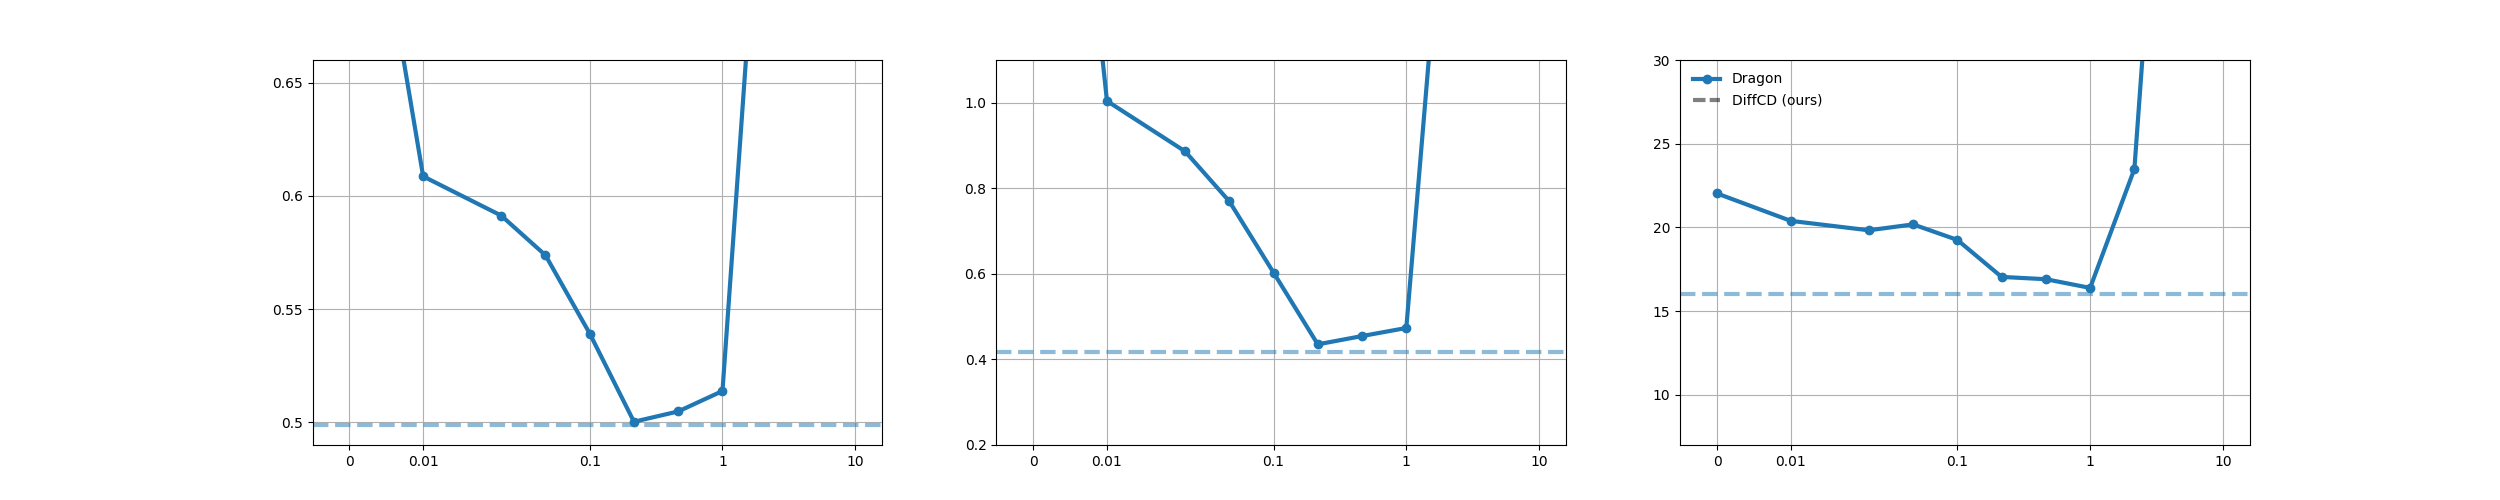

In [20]:
lw = 3

fig, ax = plt.subplots(1, 3, figsize=(25, 5), sharex=True)
for i, ((experiment_name, method, learning_rate), sub_table) in enumerate(results.groupby(['experiment_name', 'method', 'learning_rate'])):
    shape_name = get_unique(sub_table, 'gt_mesh_path').stem
    label = (shape_name if shape_name != 'LibertyBase' else 'LB').capitalize()

    # dcp_metrics = pd.read_csv(f'/mnt/dcp_outputs/famous/run-famous_noisefree-diffcd-l2-lr0.001-2024-02-12_01:19:14/{shape_name}/eval_metrics_final_40000.csv').iloc[0]
    dcp_metrics = pd.read_csv(base_dir / f'run-famous_noisefree-diffcd-implicit-256-l2-lr0.001-2024-02-12_12:23:27/{shape_name}/eval_metrics_final_40000.csv').iloc[0]

    ax[0].plot(sub_table[f'{mode}_weight'], sub_table.chamfer_distance * 100, 'o', label=label, linestyle='-' if learning_rate == 0.001 else '-', color=mpl_colors[i], linewidth=lw)
    ax[1].plot(sub_table[f'{mode}_weight'], sub_table.chamfer_square_distance * 100 ** 2, 'o', label=label, linestyle='-' if learning_rate == 0.001 else '-', color=mpl_colors[i], linewidth=lw)
    ax[2].plot(sub_table[f'{mode}_weight'], sub_table.chamfer_normal_angle, 'o', label=label, linestyle='-' if learning_rate == 0.001 else '-', color=mpl_colors[i], linewidth=lw)

    ax[0].axhline(dcp_metrics.chamfer_distance * 100, color=mpl_colors[i], linestyle='--', linewidth=lw, alpha=0.5)
    ax[1].axhline(dcp_metrics.chamfer_square_distance * 100**2, color=mpl_colors[i], linestyle='--', linewidth=lw, alpha=0.5)
    ax[2].axhline(dcp_metrics.chamfer_normal_angle, color=mpl_colors[i], linestyle='--', linewidth=lw, alpha=0.5)
ax[0].yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:g}'))

ax[-1].plot([], [], 'k--', label='DiffCD (ours)', linewidth=lw, alpha=0.5, dashes=(3, 1))
ax[-1].legend(frameon=False)
for a in ax:
    a.grid()
for a in ax:
    a.set_xscale('symlog', linthresh=0.02)
    a.set_xlim(a.get_xlim()[0], 16)
    a.set_xticks([0, 0.01, 0.1, 1, 10])
    a.set_xticklabels([0, 0.01, 0.1, 1, 10])
    a.set_xlim(-0.005, a.get_xlim()[1])
ax[0].set_yticks([0.5, 0.55, 0.6, 0.65])
ax[0].set_ylim(0.49, 0.66)
ax[1].set_ylim(0.2, 1.1)
ax[2].set_ylim(7, 30)
# ax[0].set_yticklabels([f'{tick:g}' for tick in ax[0].get_yticks()])

  0%|          | 0/11 [00:00<?, ?it/s]

Saved: 'images/results-sweep-run-famous_noisefree-igr-surfacearea-a100-mixUniform-l2-ew0.1-aw-sweep-lr0.001-2024-02-27_22:38:49/2024-07-26_16:19:53/dragonaw0.0.png'
Time: 00:04.31 (Saving: 00:00.01)

Saved: 'images/results-sweep-run-famous_noisefree-igr-surfacearea-a100-mixUniform-l2-ew0.1-aw-sweep-lr0.001-2024-02-27_22:38:49/2024-07-26_16:19:53/dragonaw0.01.png'
Time: 00:04.35 (Saving: 00:00.02)

Saved: 'images/results-sweep-run-famous_noisefree-igr-surfacearea-a100-mixUniform-l2-ew0.1-aw-sweep-lr0.001-2024-02-27_22:38:49/2024-07-26_16:19:53/dragonaw0.021544346900318832.png'
Time: 00:04.14 (Saving: 00:00.02)

Saved: 'images/results-sweep-run-famous_noisefree-igr-surfacearea-a100-mixUniform-l2-ew0.1-aw-sweep-lr0.001-2024-02-27_22:38:49/2024-07-26_16:19:53/dragonaw0.046415888336127774.png'
Time: 00:04.09 (Saving: 00:00.01)

Saved: 'images/results-sweep-run-famous_noisefree-igr-surfacearea-a100-mixUniform-l2-ew0.1-aw-sweep-lr0.001-2024-02-27_22:38:49/2024-07-26_16:19:53/dragonaw0.1.png'


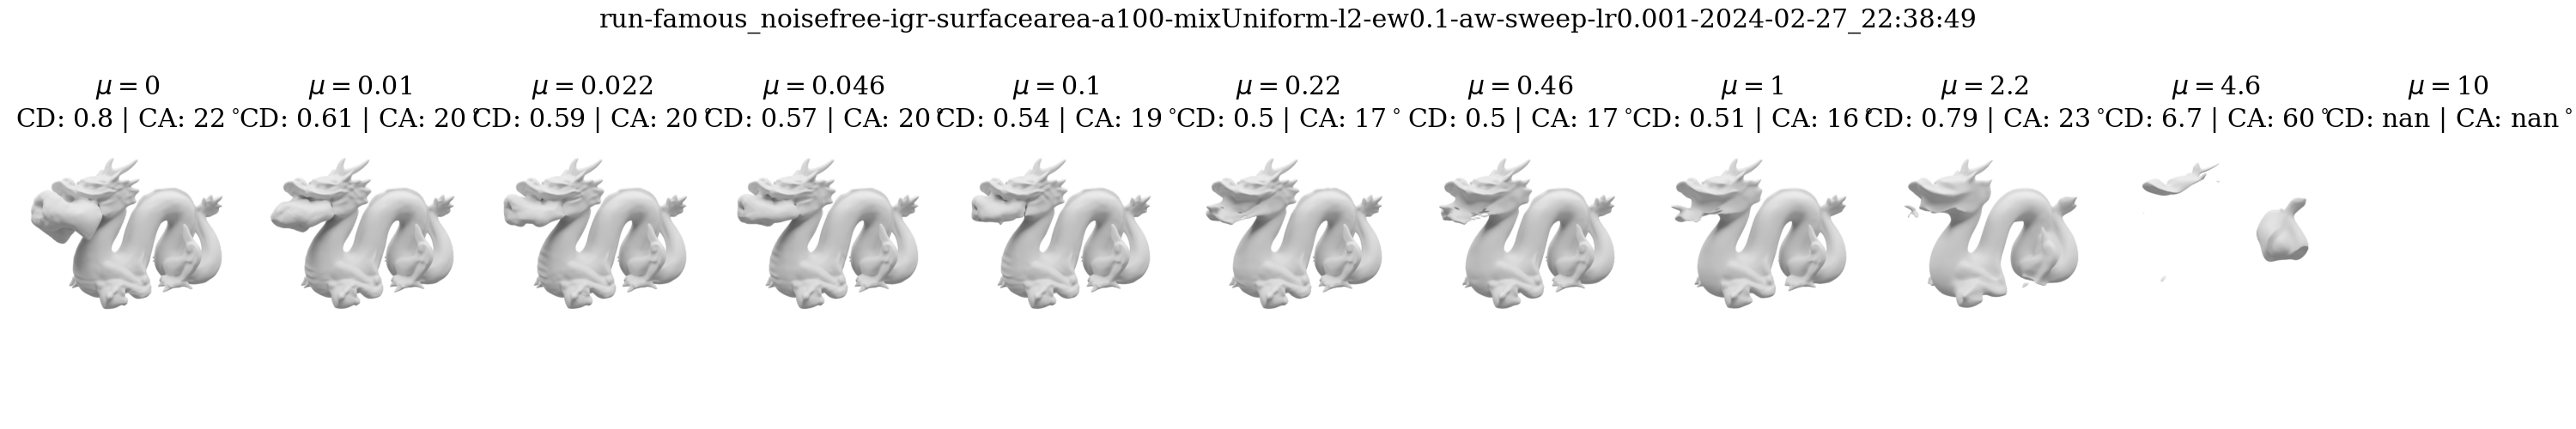

In [23]:
render = True
rotation = shape_rots['dragon']
shape_offset = np.array(shape_offsets['dragon'])
scale = shape_scales['dragon']
for (method, learning_rate), sub_table in results.groupby(['method', 'learning_rate']):
    assert len(sub_table.experiment_name.unique()) == 1
    experiment_name = sub_table.iloc[0].experiment_name

    experiment_dir = base_dir / experiment_name
    if render:
        side = 512
        timestamp_str = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
        images_dir = Path(f'images/results-sweep-{experiment_name}/{timestamp_str}')
        images_dir.mkdir(parents=True, exist_ok=False)
        images, grad_norms = [], []

    run_dirs = sorted(os.listdir(base_dir / experiment_name))
    # for i, run_name in enumerate(tqdm(run_dirs)):
    for i, (weight, row) in enumerate(tqdm(sub_table.groupby(f'{mode}_weight'))):
        assert len(row) == 1
        row = row.iloc[0]
        run_name = row.run_name

        if render:
            setup_scene(clear=True, camera_location=[-0.991957, -2.175998, 0.181080], camera_rotation=[1.523696, 0.000002, -0.431984])
        mesh_path = row.output_dir / 'mesh_final_40000.ply'
        offset = np.zeros(3) if render else np.array([i, 0, 0])

        if os.path.exists(mesh_path):
            mesh_object, scatter = plot_mesh(mesh_path, name=f'{run_name}_{weight}', color=mesh_color, offset=offset + shape_offset, rotation=rotation, scale=scale)
        else:
            print('missing', mesh_path)

        if render:
            output_path = images_dir / f"{run_name}.png"
            render_image(str(output_path), resolution=(side, side), samples=200)
            images.append(np.array(Image.open(output_path)))

            if os.path.exists(mesh_path):
                checkpoint = load_checkpoint(row.output_dir, 40000)
                train_points = np.load(row.output_dir / 'train_points.npy')
                samples = diffcd.samplers.generate_local_samples(
                    jrnd.PRNGKey(0),
                    train_points,
                    5,
                    jnp.ones(len(train_points)) * 0.001,
                )
                grads = jax.vmap(diffcd.methods.grad_norm, in_axes=(None, 0))(partial(config.model.apply, checkpoint['model']['params']), samples)
                grad_norms.append(np.array(grads))
            else:
                grad_norms.append(np.array([]))

    if render:
        img_grid = np.concatenate(images, axis=1)
        Image.fromarray(img_grid).save(images_dir / 'grid.png')

        fig, axes = plt.subplots(1, len(images), figsize=(30, 5))
        for i, image in enumerate(images):
            ax = axes[i]
            ax.imshow(image)
            row = sub_table.iloc[i]
            variable_str = {'eikonal': r'$\lambda=$', 'surface_area': r'$\mu=$'}[mode]
            value = row[f'{mode}_weight']
            ax.set_title(variable_str + f'{value:.2g}'  f"""\nCD: {row.chamfer_distance*100:.2g} | CA: {row.chamfer_normal_angle:.2g}"""  + r"$^\circ$")

            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.tick_params(left=False, bottom=False)
            ax.set_xticks([])
            ax.set_yticks([])
        fig.suptitle(sub_table.iloc[0].experiment_name)
        fig.tight_layout()
        fig.savefig(images_dir / f'grid_metrics.png', bbox_inches='tight', pad_inches=0.1)
        fig.savefig(images_dir / f'grid_metrics.pdf', bbox_inches='tight', pad_inches=0.1)

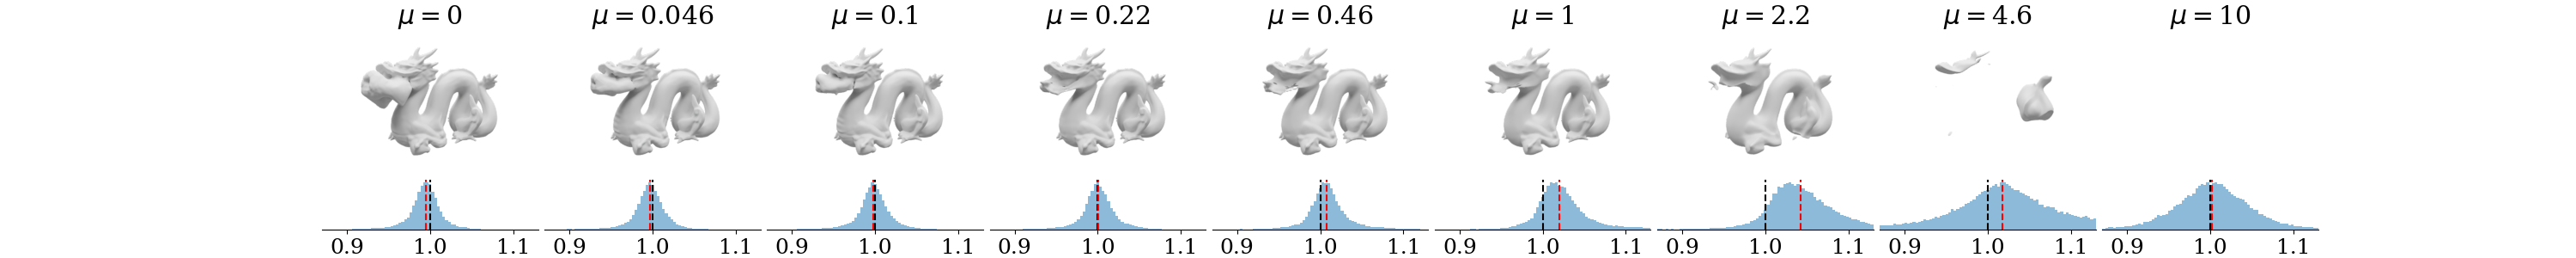

In [24]:
font = {
    'size'   : 18,
}
matplotlib.rc('font', **font)
matplotlib.rc(
    'axes',
    labelsize='xx-large',
    titlesize='large',
    labelweight='bold',
    titleweight='normal',
)
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

img_grid = np.concatenate(images, axis=1)
Image.fromarray(img_grid).save(images_dir / 'grid.png')

skip = [1, 2]
fig, axes = plt.subplots(2, len(images) - len(skip), figsize=(30, 3), gridspec_kw={'height_ratios': [3, 1]})
ax_index = 0
for i, image in enumerate(images):
    if i in skip:
        continue
    ax = axes[0, ax_index]
    ax.imshow(image)
    row = sub_table.iloc[i]
    variable_str = {'eikonal': r'$\lambda=$', 'surface_area': r'$\mu=$'}[mode]
    value = row[f'{mode}_weight']
    ax.set_title(variable_str + f'{value:.2g}')

    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(left=False, bottom=False)
    ax.set_xticks([])
    ax.set_yticks([])

    ax = axes[1, ax_index]
    xmin, xmax, pad = 0.9, 1.1, 0.03
    ax.hist(grad_norms[i], bins=np.linspace(xmin-pad, xmax+pad, 80), alpha=0.5, histtype='stepfilled')
    ax.set_xlim(xmin-pad, xmax+pad)
    ax.axvline(1, color='k', linestyle='--')
    ax.axvline(np.median(grad_norms[i]), color='r', linestyle='--')
    ax.set_yticks([])
    ax.set_xticks([xmin, 1.0, xmax])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax_index += 1

fig.subplots_adjust(wspace=.03, hspace=0) # bunny

fig.savefig(images_dir / f'grid_metrics.png', bbox_inches='tight', pad_inches=0.1)
fig.savefig(images_dir / f'grid_metrics.pdf', bbox_inches='tight', pad_inches=0.1)

## Siren loss investigation

In [41]:
results_dir = base_dir / 'run-famous_noisefree-diffcd-implicit-256-l2-lr0.001-2024-02-12_12:23:27/bunny/'
mesh_path = results_dir / 'mesh_final_40000.ply'
mesh = trimesh.load(mesh_path)
mesh.vertices = (mesh.vertices - checkpoint['center_point']) / checkpoint['scale_factor']

checkpoint = load_checkpoint(results_dir, None)
params = checkpoint['model']['params']
config = load_config(results_dir)
train_points = np.load(results_dir / 'train_points.npy')


rotation = shape_rots['bunny']
offset = shape_offsets['bunny']


In [42]:
import jax.random as jrnd

def grad_norm(f, inputs):
    return jnp.linalg.norm(jax.grad(f)(inputs))

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
r = 0.8
n_local = 5
for i, (label, samples) in enumerate([
        # ('local samples', diffcd.samplers.generate_local_samples(
        #     jrnd.PRNGKey(0),
        #     train_points,
        #     n_local,
        #     jnp.ones(len(train_points)) * 0.001,
        # )),
        ('uniform samples', diffcd.samplers.generate_global_samples(
            jrnd.PRNGKey(0),
            lower=(-r, -r, -r),
            upper=(r, r, r),
            n_points=n_local * len(train_points),
            n_dims=3,
        )),
    ]):

    scatter = bplt.Scatter(
        samples,
        marker_type='ico_spheres', radius=0.002, subdivisions=1, color=[0, 0, 0], name=label,
    )
    scatter.base_object.rotation_euler = rotation


    grads = jax.vmap(grad_norm, in_axes=(None, 0))(partial(config.model.apply, params), samples)
    ax.hist(grads.ravel(), bins=np.linspace(0.0, 1.5, 200), alpha=0.5, label=label, color=mpl_colors[i])
    ax.axvline(np.median(grads), linestyle='--', color=mpl_colors[i])
    ax.set_yticks([])
    ax.grid()
ax.legend()

In [43]:
r = 0.8
global_samples = diffcd.samplers.generate_global_samples(
    jrnd.PRNGKey(0),
    lower=(-r, -r, -r),
    upper=(r, r, r),
    n_points=10000,
    n_dims=3,
)
scatter = bplt.Scatter(
    global_samples,
    marker_type='ico_spheres', radius=0.002, subdivisions=1, color=[0, 1, 0], name=f"global samples",
    # marker_type='spheres', radius=0.008, color=[0, 0, 0], name=f"global samples",
)


In [44]:
def grad_norm(f, inputs):
    return jnp.linalg.norm(jax.grad(f)(inputs))

face_centers = mesh.vertices[mesh.faces].mean(axis=1)
plot_mesh(mesh, mesh_color)

batch_size = 50000
outs = []
compute = jax.jit(jax.vmap(grad_norm, in_axes=(None, 0)), static_argnums=0)
for i in tqdm(range(0, len(face_centers), batch_size)):
    grad_norms = compute(partial(config.model.apply, params), face_centers[i:i + batch_size])
    outs.append(np.array(grad_norms))
grad_norms = np.concatenate(outs)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

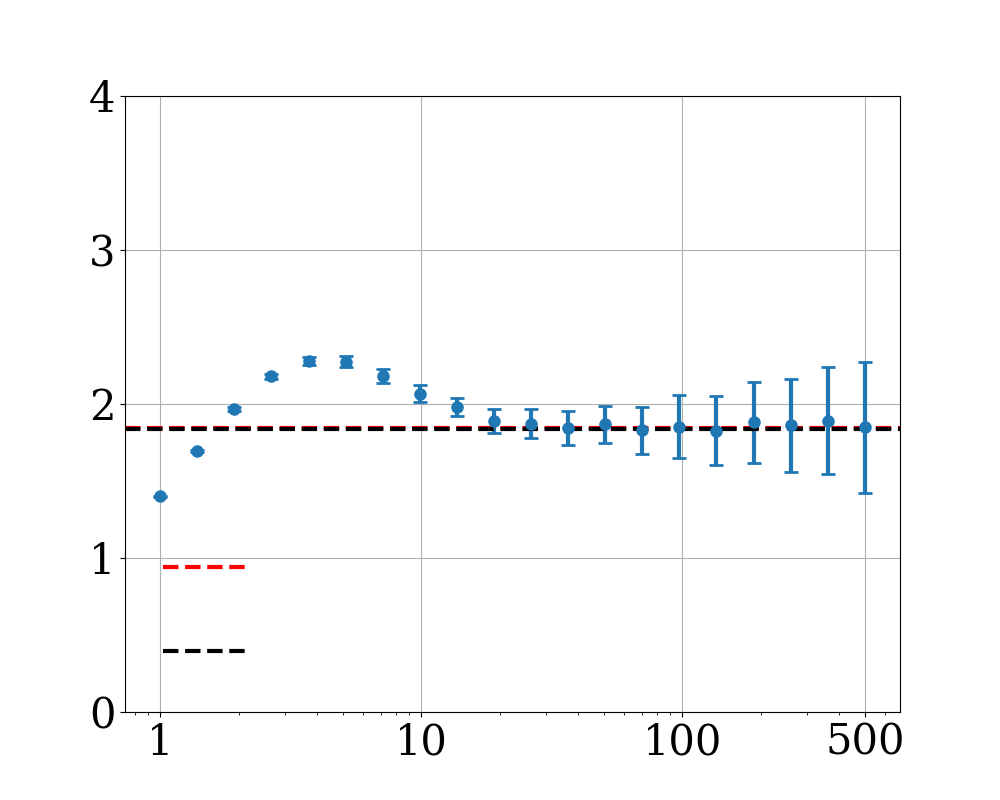

In [45]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
font = {
    'size'   : 30,
}
matplotlib.rc('font', **font)
matplotlib.rc(
    'axes',
    labelsize='xx-large',
    titlesize='large',
    labelweight='bold',
    titleweight='bold',
)
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

alpha = 100

def ssa_loss(key, alpha, r):
    samples = jax.jit(diffcd.samplers.generate_global_samples, static_argnames=('n_points', 'n_dims'))(
        key,
        lower=(-r, -r, -r),
        upper=(r, r, r),
        n_points=n_samples,
        n_dims=3,
    )
    return alpha / 2 * jnp.exp(-alpha * jnp.abs(config.model.apply(params, samples))).mean() * (2 * r) ** 3

n_steps = 20
n_trials = 100
alpha_max = 500
alphas = jnp.logspace(0, np.log10(alpha_max), n_steps)
keys = jrnd.split(jrnd.PRNGKey(0), n_steps)
key = jrnd.PRNGKey(1)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for n_samples in [5000]:
    results = []
    for i in tqdm(range(n_trials)):
        key, = jrnd.split(key, 1)
        keys = jrnd.split(key, len(alphas))
        losses = jax.vmap(ssa_loss, in_axes=(0, 0, None))(keys, alphas, 0.8)
        results.append(np.array(losses))
    results = np.array(results)
    _, caps, _ = ax.errorbar(alphas, results.mean(0), yerr=results.std(0), fmt='o', capsize=5, markersize=8, linewidth=3)
    for cap in caps:
        cap.set_markeredgewidth(2)

ax.set_xscale('log')
ax.axhline((mesh.area_faces / grad_norms).sum(), color='r', linestyle='--', label=' ', linewidth=3)
ax.axhline(mesh.area, color='k', linestyle='--', label='                   ', linewidth=3)
ax.set_xticks([1, 10, 100, alpha_max])
ax.set_xticklabels([1, 10, 100, alpha_max])
ax.set_ylim(0, 4)
ax.grid()
ax.legend(
    loc='lower left', frameon=False,
    labelspacing=1,
)
fig.show()